# Robust Phase Estimation

In [1]:
import numpy as np
from numpy import pi
from forest.benchmarking import robust_phase_estimation as rpe
from pyquil import get_qc, Program
from pyquil.gates import *

import matplotlib.pyplot as plt
%matplotlib inline

# get a qauntum computer object. Here we use a noisy qvm. 
qc = get_qc("9q-square", as_qvm=True, noisy=True)

## Estimate phase of RZ(angle, qubit)

### Generate RPE experiment

In [2]:
# we start with determination of an angle of rotation about the Z axis
rz_angle = 2 # we will use an ideal gate with phase of 2 radians
qubit = 0
rotation = RZ(rz_angle, qubit) 
# the rotation is about the Z axis; the eigenvectors are the computational basis states
# therefore the change of basis is trivially the identity. 
cob = Program()
rz_experiments = rpe.generate_rpe_experiments(rotation, *rpe.all_eigenvector_prep_meas_settings([qubit], cob))

In [3]:
print(rz_experiments)

[<forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x7f23f0f67b70>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x7f23eb3bcf98>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x7f23eb3bc780>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x7f23eb3bcd30>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x7f23eb3bcef0>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x7f23eb3bce48>]


### Acquire data

In [4]:
rz_results = rpe.acquire_rpe_data(qc, rz_experiments)

### Extract the estimate of the phase

We hope that the estimated phase is close to our choice for rz_angle=2

In [5]:
rpe.robust_phase_estimate(rz_results, [qubit])

2.0003055903476907

## Estimate phase of RX(angle, qubit)

In [6]:
rx_angle = pi # radians; only x gates with phases in {-pi, -pi/2, pi/2, pi} are allowed
qubit = 1 # let's use a different qubit
rotation = RX(rx_angle, qubit)
# the rotation has eigenvectors |+> and |->; 
# change of basis needs to rotate |0> to the plus state and |1> to the minus state
cob = RY(pi/2, qubit)
rx_experiments = rpe.generate_rpe_experiments(rotation, *rpe.all_eigenvector_prep_meas_settings([qubit], cob))

In [7]:
rx_results = rpe.acquire_rpe_data(qc, rx_experiments)
# we hope this is close to rx_angle = pi
rpe.robust_phase_estimate(rx_results, [qubit])

3.1448187563764525

## Hadamard-like rotation

We can do any rotation which is expressed in native gates (or, more generally, using gates included in basic_compile() in forest_benchmarking.compilation). There are helper functions to help determine the proper change of basis required to do such an experiment. Here, we use the fact that a Hadamard interchanges X and Z, and so must constitute a rotation about the axis (pi/4, 0) on the Bloch sphere. From this, we find the eigenvectors of an arbitrary rotation about this axis, and use those to find the change of basis matrix. Note that the change of basis need not be a program or gate; if a matrix is supplied then it will be translated to a program using a qc object's compiler. This can be done manually with a call to add_programs_to_rpe_dataframe(qc, expt) or automatically when acquire_rpe_data is called.

In [8]:
# create a program implementing the rotation of a given angle about the "Hadamard axis" 
rh_angle = 1.5  # radians
qubit = 0
RH = Program(RY(-pi / 4, qubit)).inst(RZ(rh_angle, qubit)).inst(RY(pi / 4, qubit))

# get the eigenvectors knowing the axis of rotation is pi/4, 0
evecs = rpe.bloch_rotation_to_eigenvectors(pi / 4, 0)

# get a ndarray representing the change of basis transformation
cob_matrix = rpe.get_change_of_basis_from_eigvecs(evecs)
# conver to quil using a qc object's compiler
cob = rpe.change_of_basis_matrix_to_quil(qc, [qubit], cob_matrix)

# create an experiment as usual
rh_experiments = rpe.generate_rpe_experiments(RH, *rpe.all_eigenvector_prep_meas_settings([qubit], cob))

# get the results per usual
rh_results = rpe.acquire_rpe_data(qc, rh_experiments, multiplicative_factor=2)

# the result should be close to our input rh_angle=1.5
rpe.robust_phase_estimate(rh_results, [qubit])

1.502017186285983

## Group multiple experiments to run simultaneously

This will lead to shorter data acquisition times on a QPU.

In [9]:
from forest.benchmarking.observable_estimation import ObservablesExperiment
def combine_experiments(expt1, expt2):
    program = expt1.program + expt2.program
    settings = [s1 + s2 for s1, s2 in zip(expt1, expt2)]
    return ObservablesExperiment(settings, program)

experiments = [combine_experiments(rz_expts, rx_expts) for rz_expts, rx_expts in zip(rz_experiments, rx_experiments)]

In [10]:
results = rpe.acquire_rpe_data(qc, experiments)

Iterate through the group and check that the estimates agree with previous results

In [11]:
# we expect 2 for qubit 0 and pi for qubit 1
print(rpe.robust_phase_estimate(results, [0]))
print(rpe.robust_phase_estimate(results, [1]))

1.9979230425970458
3.1432726476065986


## Upper bound on the point estimate variance

For a particular number of depths we can compute the predicted upper bound on the phase point estimate variance assuming standard parameters are used in experiment generation and data acquisition.

In [12]:
var = rpe.get_variance_upper_bound(num_depths=6)
rx_estimate = rpe.robust_phase_estimate(results, [1])

# difference between obs and actual should be less than predicted error 
print(np.abs(rx_estimate - rx_angle), ' <? ', np.sqrt(var))

0.0016799940168055194  <?  0.07727878265222556


## Visualize the rotation at each depth by plotting x and y expectations

This works best for small angles where there is less overlap at large depths

Expected:  0.19634954084936207
Observed:  0.1981856603092284


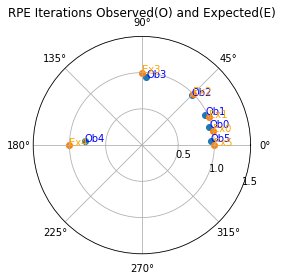

In [13]:
angle = pi/16
num_depths = 6
q = 0
cob = Program()
args = rpe.all_eigenvector_prep_meas_settings([q], cob)

expts = rpe.generate_rpe_experiments(RZ(angle,q), *args, num_depths=num_depths)
expt_res = rpe.acquire_rpe_data(qc, expts, multiplicative_factor = 100, additive_error = .1)
observed = rpe.robust_phase_estimate(expt_res, [q])
print("Expected: ", angle)
print("Observed: ", observed)

expected = [(1.0, angle*2**j) for j in range(num_depths)]

x_results = [res for depth in expt_res for res in depth if res.setting.observable[q] == 'X']
y_results = [res for depth in expt_res for res in depth if res.setting.observable[q] == 'Y']
x_exps = [res.expectation for res in x_results]
y_exps = [res.expectation for res in y_results]
x_errs = [res.std_err for res in x_results]
y_errs = [res.std_err for res in y_results]
        
ax = rpe.plot_rpe_iterations(x_exps, y_exps, x_errs, y_errs, expected)
plt.show()

## Multi qubit gates

We can also estimate the relative phases between eigenvectors of multi-qubit rotations

Note that for a particular 2q gate there are only three free eigenvalues; the fourth is determined by the special unitary condition. If we let

$$\text{rotation } = \exp{(\pi i \text{ diag}(\phi_0, \phi_1, \phi_2, \phi_3))}$$ 

then the special unitary condition is 

$$\sum_j\phi_j = 0$$ 

Our experiment will return estimates

$$[(\phi_2-\phi_0), (\phi_3-\phi_1), (\phi_1-\phi_0), (\phi_3-\phi_2) ]$$

from which each individual phases can be determined (indeed the system is over-determined).  

In the example below we demonstrate this procedure for our native CZ gate. The ideal gate has phases

$$(\phi_0=0, \phi_1=0, \phi_2=0, \phi_3=\pi)$$ 

To enforce special unitarity we ought to factor out an overall phase; let us rather note that the ideal relative phases in the order listed about are given by 

$$[0, \pi, 0, \pi]$$

In [14]:
from pyquil.gates import CZ

qubits = [0, 1]
rotation = CZ(*qubits)
cob = Program()  # CZ is diagonal in computational basis, i.e. no need to change basis
cz_expts = rpe.generate_rpe_experiments(rotation, *rpe.all_eigenvector_prep_meas_settings(qubits, cob), num_depths=7)
cz_res = rpe.acquire_rpe_data(qc, cz_expts, multiplicative_factor = 50.0, additive_error=.1)
results = rpe.robust_phase_estimate(cz_res, qubits)
# we hope to match the ideal results (0, pi, 0, pi)
print(results)

[0.0003471650832299819, 3.1457528418577763, 0.003676934230035289, 3.143674321584174]


We can also alter the experiment by indicating a preparation-and-post-selection state for some of our qubits. In this type of experiment we prepare the superposition between only a subset of the eigenvectors and so estimate only a subset of the possible relative phases. In the two qubit case below we specify that qubit 0 be prepared in the one state and that we throw out any results where qubit 0 is not measured in this state. Meanwhile, qubit 1 is still prepared in the |+> state. The preparation state is thus the superposition of eigenvectors indexed 2 and 3, and we correspondingly measure the relative phase 

$$\phi_3 - \phi_2  = \pi$$

in the ideal case

In [15]:
fixed_qubit = 0
fixed_qubit_state = 1
free_rotation_qubit = 1
post_select_args = rpe.pick_two_eigenvecs_prep_meas_settings((fixed_qubit, fixed_qubit_state), free_rotation_qubit)
cz_single_phase = rpe.generate_rpe_experiments(rotation, *post_select_args, num_depths=7)
cz_res = rpe.acquire_rpe_data(qc, cz_single_phase, multiplicative_factor = 50.0)
single_result = rpe.robust_phase_estimate(cz_res, [0, 1])
# we hope the result is close to pi
print(single_result)

[3.142735897053661]


## Characterizing a universal 1q gate set with approximately orthogonal rotation axes 
(Here we use simulated artificially imperfect gates)

In [16]:
from pyquil import Program
from pyquil.quil import DefGate, Gate
from pyquil.simulation.matrices import X as x_mat, Y as y_mat, Z as z_mat
"""
Procedure and notation follows Sections III A, B, and C in 
[RPE]  Robust Calibration of a Universal Single-Qubit Gate-Set via Robust Phase Estimation
            Kimmel et al., Phys. Rev. A 92, 062315 (2015)
            https://journals.aps.org/pra/abstract/10.1103/PhysRevA.92.062315
            arXiv:1502.02677
"""    
q = 0  # pick a qubit

pauli_vector = np.array([x_mat, y_mat, z_mat])

alpha = .01
epsilon = .02
theta = .5

# Section III A of [RPE]
gate1 = RZ(pi/2 * (1 + alpha), q) # assume some small over-rotation by fraction alpha

# let gate 2 be RX(pi/4) with over-rotation by fraction epsilon,
# and with a slight over-tilt of rotation axis by theta in X-Z plane
rx_angle = pi/4 * (1 + epsilon)
axis_unit_vector = np.array([np.cos(theta), 0, -np.sin(theta)])
mtrx = np.add(np.cos(rx_angle / 2) * np.eye(2), 
              - 1j * np.sin(rx_angle / 2) * np.tensordot(axis_unit_vector, pauli_vector, axes=1))
# Section III B of [RPE]

# get Quil definition for simulated imperfect gate
definition = DefGate('ImperfectRX', mtrx)
# get gate constructor
IRX = definition.get_constructor()
# set gate as program with definition and instruction, compiled into native gateset
gate2 = qc.compiler.quil_to_native_quil(Program([definition, IRX(q)]))
gate2 = Program([inst for inst in gate2 if isinstance(inst, Gate)])

# Section III B of [RPE], eq. III.3
# construct the program used to estimate theta
half = Program(gate1)
for _ in range(4):
    half.inst(IRX(q))
half.inst(gate1)
# compile into native gate set 
U_theta =  qc.compiler.quil_to_native_quil(Program([definition, half, half]))
U_theta = Program([inst for inst in U_theta if isinstance(inst, Gate)])


gates = [gate1, gate2, U_theta]
cobs = [I(q), RY(pi/2, q), RY(pi/2, q)]
expts = []
for gate, cob in zip(gates, cobs):
    args = rpe.all_eigenvector_prep_meas_settings([q], cob)
    expts.append(rpe.generate_rpe_experiments(gate, *args))
expts_results = [rpe.acquire_rpe_data(qc, expt, multiplicative_factor = 50.0, additive_error=.15) for expt in expts]

results = []
for ress in expts_results:
    result = rpe.robust_phase_estimate(ress, [q])
    results += [result]
    
print("Expected Alpha: " + str(alpha))
print("Estimated Alpha: " + str(results[0]/(pi/2) - 1))
print()
print("Expected Epsilon: " + str(epsilon))
epsilon_est = results[1]/(pi/4) - 1
print("Estimated Epsilon: " + str(epsilon_est))
print()
print("Expected Theta: " + str(theta))
print("Estimated Theta: " + str(np.sin(results[2]/2)/(2*np.cos(epsilon_est * pi/2))))

Expected Alpha: 0.01
Estimated Alpha: 0.011438052229321594

Expected Epsilon: 0.02
Estimated Epsilon: 0.018858130827586583

Expected Theta: 0.5
Estimated Theta: 0.42014250201187675


## Customizing the noise model

In [17]:
from pandas import Series
from pyquil.noise import damping_after_dephasing
from pyquil.quil import Measurement
qc = get_qc("9q-square", as_qvm=True, noisy=False)

def add_damping_dephasing_noise(prog, T1, T2, gate_time):
    p = Program()
    p.defgate("noise", np.eye(2))
    p.define_noisy_gate("noise", [0], damping_after_dephasing(T1, T2, gate_time))
    for elem in prog:
        p.inst(elem)
        if isinstance(elem, Measurement):
            continue  # skip measurement
        p.inst(("noise", 0))
    return p

def add_noise_to_experiments(expt, t1, t2, p00, p11):
    gate_time = 200 * 10 ** (-9)
    for expt in expts:
        expt.program = add_damping_dephasing_noise(expt.program, t1, t2, gate_time).define_noisy_readout(0, p00, p11)

angle = 1
q = 0
RH = Program(RY(-pi / 4, q)).inst(RZ(angle, q)).inst(RY(pi / 4, q))
evecs = rpe.bloch_rotation_to_eigenvectors(pi / 4, 0)
# get a ndarray representing the change of basis transformation
cob_matrix = rpe.get_change_of_basis_from_eigvecs(evecs)
# convert to quil using a qc object's compiler
cob = rpe.change_of_basis_matrix_to_quil(qc, [q], cob_matrix)
# create an experiment as usual
expts = rpe.generate_rpe_experiments(RH, *rpe.all_eigenvector_prep_meas_settings([q], cob), num_depths=7)
# add noise to experiment with desired parameters
add_noise_to_experiments(expts, 25 * 10 ** (-6.), 20 * 10 ** (-6.), .92, .87)
res = rpe.acquire_rpe_data(qc, expts, multiplicative_factor=5., additive_error=.15)

# we hope this is close to angle=1
rpe.robust_phase_estimate(res, [q])

1.004874836115469

You can also change the noise model of the qvm directly

In [18]:
from pyquil.noise import decoherence_noise_with_asymmetric_ro, _decoherence_noise_model, _get_qvm_noise_supported_gates
# noise_model = decoherence_noise_with_asymmetric_ro(qc.device.get_isa(), p00=0.92, p11=.87)
T1=20e-6
T2=10e-6
gates = _get_qvm_noise_supported_gates(qc.quantum_processor.to_compiler_isa())
noise_model = _decoherence_noise_model(gates=gates, T1=T1, T2=T2, ro_fidelity=1.)

qc = get_qc("9q-square", as_qvm=True, noisy=False)
qc.qam.noise_model = noise_model

decohere_expts = rpe.generate_rpe_experiments(RH, *rpe.all_eigenvector_prep_meas_settings([q], cob), num_depths=7)
res = rpe.acquire_rpe_data(qc, decohere_expts, multiplicative_factor=5., additive_error=.15)
rpe.robust_phase_estimate(res, [q])

1.0015588207846218